# Anomaly Detection with K-Means, Isolation Forest in Valeo

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.metrics import average_precision_score, precision_score, \
                        recall_score, precision_recall_curve, roc_curve, \
                        roc_auc_score

# Libraries from Andrea Araldo
! wget https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/course_library/andrea_models.py
! wget https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/course_library/visualization.py
from andrea_models import subsample
from visualization import silhouette_diagram

from visualization import silhouette_diagram, plot_conf_mat, \
                      false_positive_rate, evaluate_anomaly_detector

# To show time at each cell
# Credits to https://medium.com/@arptoth/how-to-measure-execution-time-in-google-colab-707cc9aad1c8
!pip install ipython-autotime 
%load_ext autotime

--2022-02-06 14:18:12--  https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/course_library/andrea_models.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3190 (3.1K) [text/plain]
Saving to: ‘andrea_models.py.5’

andrea_models.py.5  100%[===================>]   3.12K  --.-KB/s    in 0s      

2022-02-06 14:18:12 (47.8 MB/s) - ‘andrea_models.py.5’ saved [3190/3190]

--2022-02-06 14:18:12--  https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/course_library/visualization.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


time: 2.57 ms (started: 2022-02-06 14:18:19 +00:00)


In [2]:
np.random.seed(9)
random.seed(9) 

time: 26.3 ms (started: 2022-02-06 14:18:19 +00:00)


Import the Dataset

In [3]:
path = "https://raw.githubusercontent.com/Werner-DB/ML_Project/main/PreProcessing/dataset_cleaned.csv" # path for the preprocessed datadet
!wget $path

--2022-02-06 14:18:19--  https://raw.githubusercontent.com/Werner-DB/ML_Project/main/PreProcessing/dataset_cleaned.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3429217 (3.3M) [text/plain]
Saving to: ‘dataset_cleaned.csv.2’

dataset_cleaned.csv 100%[===================>]   3.27M  --.-KB/s    in 0.06s   

2022-02-06 14:18:20 (58.6 MB/s) - ‘dataset_cleaned.csv.2’ saved [3429217/3429217]

time: 569 ms (started: 2022-02-06 14:18:19 +00:00)


In [4]:
df = pd.read_csv("dataset_cleaned.csv", index_col="PROC_TRACEINFO")
df.head()

,OP070_V_1_angle_value,OP090_SnapRingPeakForce_value,OP070_V_2_angle_value,OP120_Rodage_I_mesure_value,OP090_SnapRingFinalStroke_value,OP110_Vissage_M8_torque_value,OP120_Rodage_U_mesure_value,OP070_V_1_torque_value,OP090_StartLinePeakForce_value,OP110_Vissage_M8_angle_value,OP090_SnapRingMidPointForce_val,OP070_V_2_torque_value,results
PROC_TRACEINFO,,,,,,,,,,,,,
I-B-XA1207672-190429-00688,180.4,190.51,173.1,113.64,12.04,12.16,11.97,6.62,26.37,18.8,109.62,6.60,0
I-B-XA1207672-190828-00973,138.7,147.70,163.5,109.77,12.12,12.19,11.97,6.41,21.03,18.5,105.48,6.40,0
I-B-XA1207672-190712-03462,180.9,150.87,181.2,109.79,11.86,12.24,11.97,6.62,25.81,17.5,100.03,6.61,0
I-B-XA1207672-190803-00051,173.5,159.56,151.8,113.25,11.82,12.35,11.97,6.62,24.62,15.6,104.94,6.61,0
I-B-XA1207672-190508-03248,174.5,172.29,177.5,112.88,12.07,12.19,11.97,6.62,29.22,33.6,99.19,6.61,0


time: 232 ms (started: 2022-02-06 14:18:20 +00:00)


In [5]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 34515 entries, I-B-XA1207672-190429-00688 to I-B-XA1207672-190712-03433
Data columns (total 13 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OP070_V_1_angle_value            34515 non-null  float64
 1   OP090_SnapRingPeakForce_value    34515 non-null  float64
 2   OP070_V_2_angle_value            34515 non-null  float64
 3   OP120_Rodage_I_mesure_value      34515 non-null  float64
 4   OP090_SnapRingFinalStroke_value  34515 non-null  float64
 5   OP110_Vissage_M8_torque_value    34515 non-null  float64
 6   OP120_Rodage_U_mesure_value      34515 non-null  float64
 7   OP070_V_1_torque_value           34515 non-null  float64
 8   OP090_StartLinePeakForce_value   34515 non-null  float64
 9   OP110_Vissage_M8_angle_value     34515 non-null  float64
 10  OP090_SnapRingMidPointForce_val  34515 non-null  float64
 11  OP070_V_2_torque_value           34515 

In [6]:
df['results'].value_counts()

0    34210
1      305
Name: results, dtype: int64

time: 7.41 ms (started: 2022-02-06 14:18:20 +00:00)


In [7]:
num_of_normal = sum( df['results']==0 )
num_of_anomalies = sum( df['results']==1 )
num_of_anomalies/num_of_normal

0.008915521777258111

time: 21.2 ms (started: 2022-02-06 14:18:20 +00:00)


Prepare a DataSet without the true label column for scaling

In [8]:
X = df.drop('results', axis=1)

time: 4.63 ms (started: 2022-02-06 14:18:20 +00:00)


In [9]:
y = [1 if c==1 else 0 for c in df['results']] 

time: 12.7 ms (started: 2022-02-06 14:18:20 +00:00)


Perform Standard Scaling

In [10]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

time: 18.3 ms (started: 2022-02-06 14:18:20 +00:00)


# K-means clustering

Try to find the good k value with the entire Dataset but wihtout the true label to find all the hyper parameters. Best number of k, how many cluster we want, what is the best number of initialization of centroids.

In [11]:
K =3
model = KMeans(n_clusters=K)
clusters = model.fit_predict(X_scaled)

time: 1.26 s (started: 2022-02-06 14:18:20 +00:00)


In [12]:
clusters[0:5]

array([2, 1, 2, 2, 2], dtype=int32)

time: 16.4 ms (started: 2022-02-06 14:18:22 +00:00)


(array([ 3407.,     0.,     0.,     0.,     0., 10367.,     0.,     0.,
            0., 20741.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

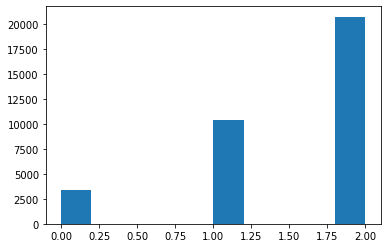

time: 384 ms (started: 2022-02-06 14:18:22 +00:00)


In [13]:
plt.hist(clusters)

In [14]:
model.inertia_

285354.397052497

time: 4.87 ms (started: 2022-02-06 14:18:22 +00:00)


### Random initializations

In sklearn, Kmeans algorithm is repeated `n_init` times (by default 10), so to produce 10 models. The model with the smallest inertia is selected.

How to know if `n_init` is enough or we should increase it? Intuitively, the more the dimensions (features), the more random initializations we would need.

Suggestion: Repeat KMeans many times, increasing `n_init` until you see that the inertia stops improving.

To go fast, do this on a smaller subset.

In [15]:
n_samples = 10000
X_sub = subsample(X_scaled, n_samples)

time: 10.1 ms (started: 2022-02-06 14:18:22 +00:00)


Inertia with  10  initializations: 87214.71436606368
Inertia with  20  initializations: 87214.70441205209
Inertia with  30  initializations: 87214.70441205209
Inertia with  40  initializations: 87214.70441205209
Inertia with  50  initializations: 87214.70441205209
Inertia with  60  initializations: 87214.70441205209
Inertia with  70  initializations: 87214.70441205209
Inertia with  80  initializations: 87214.70441205209
Inertia with  90  initializations: 87214.70441205209
Inertia with  100  initializations: 87214.70441205209
Inertia with  110  initializations: 87214.70441205209
Inertia with  120  initializations: 87214.70441205209
Inertia with  130  initializations: 87214.70441205209
Inertia with  140  initializations: 87214.70441205209
Inertia with  150  initializations: 87214.70441205209
Inertia with  160  initializations: 87214.70441205209
Inertia with  170  initializations: 87214.70441205209
Inertia with  180  initializations: 87214.70441205209
Inertia with  190  initializations: 8

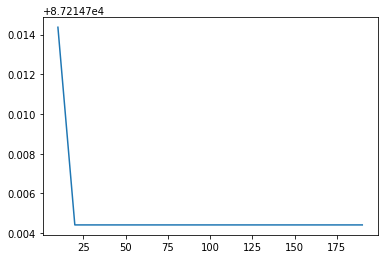

time: 1min 37s (started: 2022-02-06 14:18:22 +00:00)


In [16]:
inertia_values = []

repeats = range(10, 200, 10)

for r in repeats:
  model = KMeans(K, n_init=r)
  model.fit_predict(X_sub)
  inertia_values.append(model.inertia_)
  print("Inertia with ", r, " initializations:", model.inertia_)

plt.plot(repeats, inertia_values)

In [17]:
n_init = 20

time: 1.68 ms (started: 2022-02-06 14:20:00 +00:00)


# Silhouette

First compute the distance between all the samples.

In [18]:
print("Distances to be computed: ", "{:e}".format( X_scaled.shape[0]**2) )

Distances to be computed:  1.191285e+09
time: 3.35 ms (started: 2022-02-06 14:20:00 +00:00)


In [19]:
model = KMeans(K, n_init=n_init)
clusters = model.fit_predict(X_sub)

time: 982 ms (started: 2022-02-06 14:20:00 +00:00)


In [20]:
silhouette_avg = silhouette_score(X_sub, clusters)
silhouette_avg

0.2583492608158188

time: 2.38 s (started: 2022-02-06 14:20:01 +00:00)


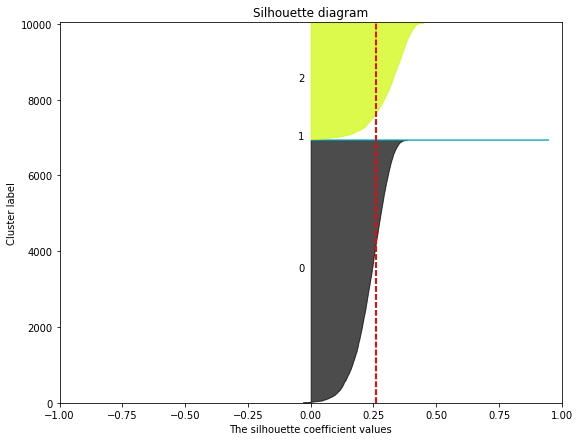

time: 4.41 s (started: 2022-02-06 14:20:03 +00:00)


In [21]:
sample_silhouette_values = silhouette_diagram(X_sub, clusters, K)

For K= 2  the silhouette score is  0.25530075437628713
For K= 3  the silhouette score is  0.25834723665753206
For K= 4  the silhouette score is  0.17530029449551848
For K= 5  the silhouette score is  0.1893057537539772
For K= 6  the silhouette score is  0.17113923138843581
For K= 7  the silhouette score is  0.16075749599193181
For K= 8  the silhouette score is  0.15680943269336248
For K= 9  the silhouette score is  0.14695785162254163
For K= 10  the silhouette score is  0.1359915722746695
For K= 11  the silhouette score is  0.13557936662666442


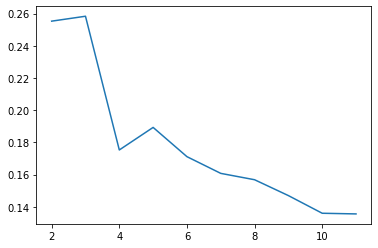

time: 1min 2s (started: 2022-02-06 14:20:07 +00:00)


In [22]:
max_clusters = 12

scores = []

for K in range (2,max_clusters):
  # To avoid using always the same seed, let's change the random state every time
  model = KMeans(K, n_init=n_init)
  clusters = model.fit_predict(X_sub)

  silhouette_avg = silhouette_score(X_sub, clusters)
  scores.append(silhouette_avg)
  print ("For K=",K, " the silhouette score is ", silhouette_avg)

plt.plot(range (2,max_clusters), scores)

In [23]:
K=4
n_init = 20

time: 1.35 ms (started: 2022-02-06 14:21:10 +00:00)


# Anomaly Detection

We are going to run KMeans with our hyperparameters K=4 and n_init=20

In [24]:
X_scaled, y = shuffle(X_scaled, y)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.5)

time: 32.3 ms (started: 2022-02-06 14:21:10 +00:00)


In [25]:
model = KMeans(K, n_init=n_init)
clusters = model.fit_predict(X_train)

time: 1.75 s (started: 2022-02-06 14:21:10 +00:00)


In [26]:
anomaly_scores = model.transform(X_train).min(axis=1)

time: 10.2 ms (started: 2022-02-06 14:21:12 +00:00)


Text(0.5, 0, 'Recall')

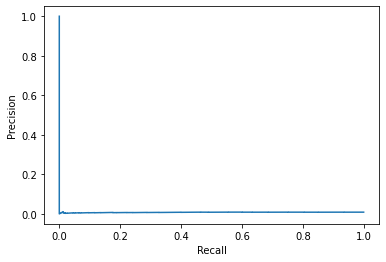

time: 223 ms (started: 2022-02-06 14:21:12 +00:00)


In [27]:
precision, recall, thresholds = precision_recall_curve(y_train, anomaly_scores)
plt.plot(recall, precision)
plt.ylabel('Precision')
plt.xlabel('Recall')